In [14]:
# Imports
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import pandas as pd
import colorcet as cc
from scipy.stats import rankdata

In [15]:
# Set plot style
sns.set_palette("colorblind")
sns.set_style("ticks")
sns.set_context("poster")
color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
cmap = "flare"

## Figure 2: Correlation of Agent Importance, Shapley values and Individual agent rewards. 

In [16]:
# Read in the data
data_path = "minimal_experiment_data/importance_correlation"

json_path = f"{data_path}/vdn/lbforaging:Foraging-15x15-4p-5f-v2/0/agent_importance/master_agent_importance.json"
with open(json_path, "r") as file:
    importance = json.load(file)
json_path = f"{data_path}/vdn/lbforaging:Foraging-15x15-4p-5f-v2/0/individual_reward/master_individual_reward.json"
with open(json_path, "r") as file:
    individual_reward = json.load(file)

json_path = f"{data_path}/vdn/lbforaging:Foraging-15x15-4p-5f-v2/0/shapley_value/master_shapley_value.json"
with open(json_path, "r") as file:
    shap = json.load(file)

json_path = f"{data_path}/vdn/rware:rware-small-4ag-v1/0/agent_importance/master_agent_importance.json"
with open(json_path, "r") as file:
    importance1 = json.load(file)
json_path = f"{data_path}/vdn/rware:rware-small-4ag-v1/0/individual_reward/master_individual_reward.json"
with open(json_path, "r") as file:
    individual_reward1 = json.load(file)

json_path = f"{data_path}/vdn/rware:rware-small-4ag-v1/0/shapley_value/master_shapley_value.json"
with open(json_path, "r") as file:
    shap1 = json.load(file)

In [17]:
# Data normalization function
def normalize_data(data, metric, norm_data, tp):
    # Get the number of agents and time steps
    agent_keys = [k for k in data[list(data.keys())[0]].keys() if k.endswith(metric)]

    # Initialize a dictionary to store agent importance values
    agent_values = {key: [] for key in agent_keys}

    # Iterate through the time steps and collect agent importance values
    max_val = 0
    for time_step in data.keys():
        for agent_key in agent_keys:
            agent_values[agent_key].append(np.mean(data[time_step][agent_key]))
            if max_val < np.max(np.mean(data[time_step][agent_key])):
                max_val = np.max(np.mean(data[time_step][agent_key]))

    for agent_key in agent_values.keys():
        agent_id = agent_key.split("_")[1]
        if f"a{agent_id}_{tp}" not in norm_data.keys():
            norm_data[f"a{agent_id}_{tp}"] = []
        if max_val != 0:
            norm_data[f"a{agent_id}_{tp}"] = (
                norm_data[f"a{agent_id}_{tp}"] + agent_values[agent_key]
            )
        else:
            norm_data[f"a{agent_id}_{tp}"] = (
                norm_data[f"a{agent_id}_{tp}"] + agent_values[agent_key]
            )

    return norm_data

In [18]:
# Process data and create relevant dataframes
vdn_lbf = {}
vdn_lbf = normalize_data(importance, "_importance_value", vdn_lbf, "i")
vdn_lbf = normalize_data(individual_reward, "_reward", vdn_lbf, "r")
vdn_lbf = normalize_data(shap, "_shapley_value", vdn_lbf, "s")

vdn_rware = {}
vdn_rware = normalize_data(importance1, "_importance_value", vdn_rware, "i")
vdn_rware = normalize_data(individual_reward1, "_reward", vdn_rware, "r")
vdn_rware = normalize_data(shap1, "_shapley_value", vdn_rware, "s")

data = {}
for key in ["a0_i", "a0_r", "a0_s"]:
    data[key] = vdn_lbf[key]


vdn_lbf_df = pd.DataFrame(vdn_lbf)
vdn_rware_df = pd.DataFrame(vdn_rware)
vdn_lbf_df = pd.DataFrame(dict(sorted(vdn_lbf.items(), key=lambda x: x[0])))
vdn_rware_df = pd.DataFrame(dict(sorted(vdn_rware.items(), key=lambda x: x[0])))

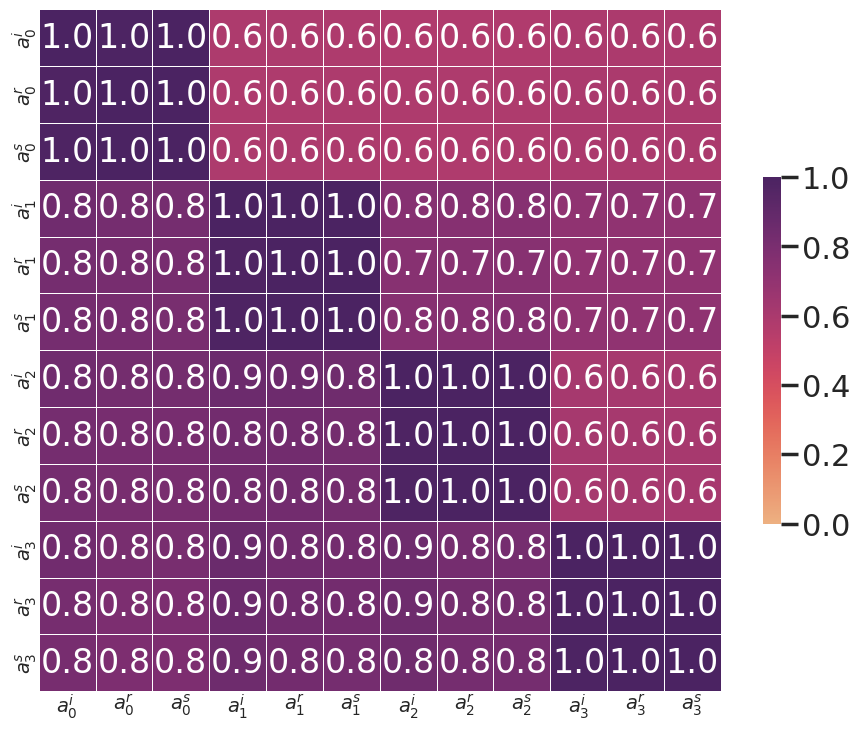

In [19]:
# Produces heat map

n_agents = 4
heatmap_labels = [
    f"$a^{char}_{id}$" for id in range(n_agents) for char in ("i", "r", "s")
]

# Compute the correlation matrix
vdn_lbf_corr = vdn_lbf_df.corr().values
vdn_rware_corr = vdn_rware_df.corr().values

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(vdn_lbf_corr, dtype=bool))
mask2 = np.triu(np.ones_like(vdn_rware_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

cmap = "flare"
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    vdn_lbf_corr,
    mask=mask,
    vmin=0,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    cmap=cmap,
    annot=True,
    fmt=".1f",
)

sns.heatmap(
    vdn_rware_corr,
    mask=~mask2,
    vmin=0,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar=False,
    cmap=cmap,
    annot=True,
    fmt=".1f",
)

# Create and add the labels
ax.set_xticks(np.arange(len(heatmap_labels)) + 0.5)
ax.set_xticklabels(heatmap_labels, ha="center", fontsize=14, weight="bold")
ax.set_yticks(np.arange(len(heatmap_labels)) + 0.5)
ax.set_yticklabels(heatmap_labels, va="center", fontsize=14, weight="bold")


# Center-align the labels for each entry
ax.tick_params(axis="x", pad=0, size=0)
ax.tick_params(axis="y", pad=0, size=0)

plt.show()

## Ranking matching plots 

In [20]:
def rank(data, metric, norm_data, tp):
    def list_to_rank(lst):
        ranks = rankdata(lst, method="ordinal")
        return list(map(int, ranks))

    # Get the number of agents and time steps
    agent_keys = [k for k in data[list(data.keys())[0]].keys() if k.endswith(metric)]

    # Initialize a dictionary to store agent importance values
    agent_values = {key: [] for key in agent_keys}

    # Iterate through the time steps and collect agent importance values
    max_val = 0
    for time_step in data.keys():
        for agent_key in agent_keys:
            agent_values[agent_key].append(np.mean(data[time_step][agent_key]))
            if max_val < np.max(np.mean(data[time_step][agent_key])):
                max_val = np.max(np.mean(data[time_step][agent_key]))
    for i in range(len(agent_values[f"agent_0{metric}"])):
        l = []
        for agent_key in agent_values.keys():
            l.append(agent_values[agent_key][i])
        l = list_to_rank(l)

        j = 0
        for agent_key in agent_values.keys():
            agent_id = agent_key.split("_")[1]
            if f"a{agent_id}_{tp}" not in norm_data.keys():
                norm_data[f"a{agent_id}_{tp}"] = []

            norm_data[f"a{agent_id}_{tp}"].append(l[j])
            j += 1

    return norm_data

In [21]:
# Process data for ranking

vdn_lbf = {}
vdn_lbf = rank(importance, "_importance_value", vdn_lbf, "i")
vdn_lbf = rank(individual_reward, "_reward", vdn_lbf, "r")
vdn_lbf = rank(shap, "_shapley_value", vdn_lbf, "s")

vdn_rware = {}
vdn_rware = rank(importance1, "_importance_value", vdn_rware, "i")
vdn_rware = rank(individual_reward1, "_reward", vdn_rware, "r")
vdn_rware = rank(shap1, "_shapley_value", vdn_rware, "s")

data = {}
for key in ["a0_i", "a0_r", "a0_s"]:
    data[key] = vdn_lbf[key]

In [22]:
def count_mismatched_values(l1, l2):
    count = 0

    for i in range(len(l1)):
        if l1[i] != l2[i]:
            count += 1

    return count


def percentage(k, l):
    return (l - k) / l * 100


def mismatch(data):
    d = {}
    l = 0
    numbers = [key.split("_")[0][1:] for key in data.keys()]
    for number in numbers:
        if l == 0:
            l = len(data[f"a{number}_i"])
        d[f"a{number}_i-r"] = percentage(
            count_mismatched_values(data[f"a{number}_i"], data[f"a{number}_r"]), l
        )
        d[f"a{number}_s-r"] = percentage(
            count_mismatched_values(data[f"a{number}_s"], data[f"a{number}_r"]), l
        )

    return d

In [23]:
n_agents = 4
ranking_labels = [f"$a_{id}$" for id in range(n_agents)]


def plot_ranking_data(data_df):
    # Set the plot size
    f, ax = plt.subplots(figsize=(10, 5))
    # Group the data by the numbers in the keys
    grouped_data = {}
    for key, value in data_df.items():
        number = key.split("_")[0][1:]
        if f"a{number}" not in grouped_data:
            grouped_data[f"a{number}"] = {}
        group = key.split("_")[1]
        grouped_data[f"a{number}"][group] = value
    # Convert the grouped data to a DataFrame
    df = pd.DataFrame.from_dict(grouped_data, orient="index")

    # Reset the index and rename the column
    df = df.reset_index().rename(columns={"index": "Numbers"})

    # Melt the DataFrame to convert it to long format
    df_melted = df.melt(id_vars="Numbers", var_name="Group", value_name="Value")

    # Plotting
    sns.barplot(data=df_melted, x="Numbers", y="Value", hue="Group")

    # Set y-axis label
    ax.set_ylabel("Ranking match %")
    ax.set_xlabel("Agents")
    # Create and add the labels
    ax.set_xticks(np.arange(len(ranking_labels)))
    ax.set_xticklabels(ranking_labels, ha="center", fontsize=14, weight="bold")

    # Show the legend
    plt.legend()

    # Display the plot
    plt.show()

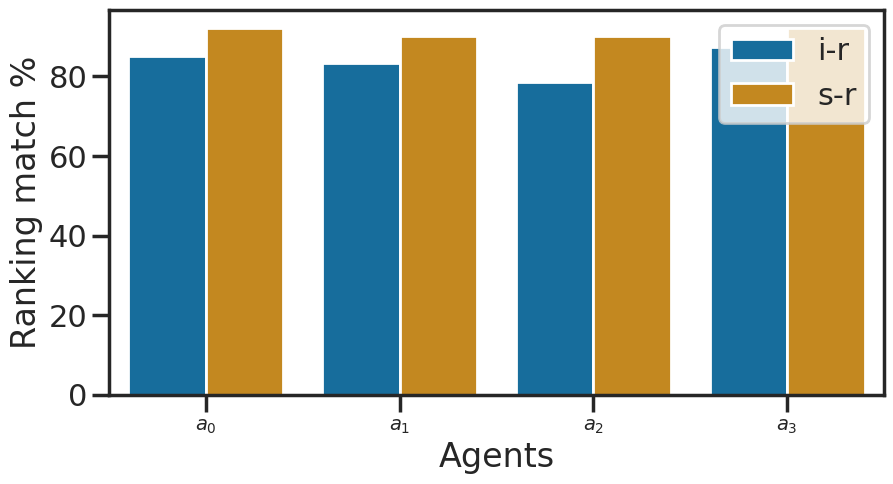

In [24]:
data = mismatch(vdn_lbf)
plot_ranking_data(data)

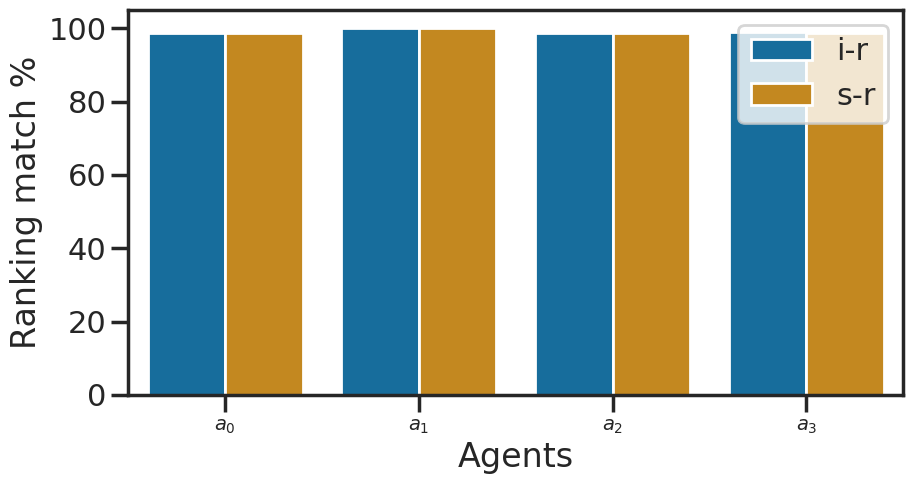

In [25]:
data = mismatch(vdn_rware)
plot_ranking_data(data)